In [1]:
cd /om2/user/leokoz8/code/rnns-of-rnns

/rdma/vast-rdma/vast/fiete/leokoz8/code/rnns-of-rnns


In [130]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import tqdm
from src import models, utils, parametrizations,tasks,running
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau

from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
from neurogym.wrappers.block import MultiEnvs
from neurogym import Dataset
from Mod_Cog.mod_cog_tasks import *

envs, env_names = tasks.load_all_mod_cog_tasks()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
import pickle
filepath = '/om2/user/leokoz8/code/rnns-of-rnns/models/spectral/dlygointr/conformal/perf_over_training.pickle'
file = torch.load(filepath)
file

tensor([0.0500, 0.0450, 0.0400, 0.0600, 0.0700])

In [119]:
device = "cuda" if torch.cuda.is_available() else "cpu"


dataset = Dataset(ctxdlydm1seql(), batch_size=64, seq_len=100)
env = dataset.env


tasks_and_constraints  = [(envs_names[i],'spectral') for i in range(0,19)]
    
net = utils.build_GWNET_from_pretrained(tasks_and_constraints, env, device, gw_hidden_size = 16, interareal_constraint = 'None')

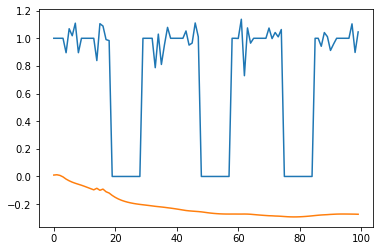

In [120]:
inputs, labels = dataset()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)

labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

with torch.no_grad():
    # forward + backward + optimize
    outputs,rnn_outputs = net(inputs)
    plt.plot(inputs[:,1,0].detach().cpu())
    plt.plot(rnn_outputs[:,1,0].detach().cpu())

In [132]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.1)

num_gradient_steps = 1000
eval_every = 25

training_params = {"num_gradient_steps": num_gradient_steps, "eval_every": eval_every}


net_trained, perf_over_training = running.train(net,dataset,criterion,optimizer, scheduler, training_params,device)



Gradient step: 0 	 Performance: 0.41 	 Training loss: 0.38
Gradient step: 9 	 Performance: 0.565 	 Training loss: 3.41
Gradient step: 19 	 Performance: 0.55 	 Training loss: 3.22
Gradient step: 29 	 Performance: 0.575 	 Training loss: 3.08
Gradient step: 39 	 Performance: 0.7 	 Training loss: 2.82
Gradient step: 49 	 Performance: 0.605 	 Training loss: 2.71
Gradient step: 59 	 Performance: 0.69 	 Training loss: 2.49
Gradient step: 69 	 Performance: 0.755 	 Training loss: 2.32
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/om/user/leokoz8/envs/rnns-of-rnns-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_27546/48402889.py", line 11, in <cell line: 11>
    net_trained, perf_over_training = running.train(net,dataset,criterion,optimizer, scheduler, training_params,device)
  File "/rdma/vast-rdma/vast/fiete/leokoz8/code/rnns-of-rnns/src/running.py", line 37, in train
    outputs,rnn_outputs = net(inputs)
  File "/om/user/leokoz8/envs/rnns-of-rnns-env/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/rdma/vast-rdma/vast/fiete/leokoz8/code/rnns-of-rnns/src/models.py", line 409, in forward
    rnn_output, _ = self.rnn(x)
  File "/om/user/leokoz8/envs/rnns-of-rnns-env/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call

In [149]:
perf_over_training

tensor([0.0700, 0.0450, 0.0750, 0.0550, 0.0650, 0.0850, 0.0550, 0.0700, 0.0850,
        0.0600, 0.1000, 0.1000, 0.1000, 0.1850, 0.2700, 0.1350, 0.2200, 0.3250,
        0.3250, 0.2200, 0.3850, 0.3700, 0.4750, 0.5650, 0.4950, 0.5150, 0.5550,
        0.6200, 0.5750, 0.6450, 0.7250, 0.6300, 0.5850, 0.7600, 0.7000, 0.7450,
        0.6000, 0.7500, 0.7100, 0.8150, 0.7100, 0.8150, 0.7950, 0.8750, 0.7550,
        0.8200, 0.8550, 0.6750, 0.8400, 0.8700, 0.8900, 0.5350, 0.8100, 0.7900,
        0.8250, 0.8850, 0.8950, 0.8850, 0.8150, 0.8850, 0.8600, 0.8700, 0.9100,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

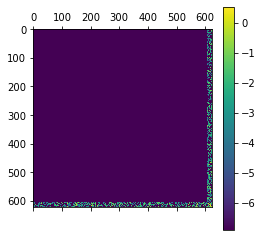

In [112]:
with torch.no_grad():
    plt.matshow(utils.log_abs(net.rnn.L_hat.weight[:,:].detach().cpu()))
    plt.colorbar()

In [116]:
input2h_weight_bar, rnn_input2h_bias, rnn_h2h_weight, rnn_h2h_bias, fc_weight_bar, fc_bias_bar = utils.get_stacked_weights_and_biases(tasks_and_constraints)

In [153]:
with torch.no_grad():
    n = 32
    D = torch.diag(torch.rand(n,device = device))
    W = rnn_h2h_weight[5]
    I = torch.eye(n,device = device)
    J = -I + D @ W
    M = compute_metric_from_sym_weights(W)
    F = 0.5*(M @ J + J.T @ M)
    
    e,_ = torch.linalg.eig(F)
    print(torch.max(torch.real(e)))

tensor(-1.9924, device='cuda:0')
